# **Experiment: Expanding the Range of Predicted Returns by Fine-Tuning a Base Model**

---

### **Problem Statement**

When using the GPT-4 base model to predict 21-day stock returns at scale, the model consistently produces a narrow range of predictions. It rarely forecasts returns greater than or equal to 7% or less than or equal to -6%, indicating a conservative bias. This limitation arises without any explicit bias introduced in the prompts.

### **Hypotheses**

1. **Hypothesis 1: Expanding Prediction Range Through Fine-Tuning**  
   *Fine-tuning the model to learn the associations between information in user prompts and the actual 21-day returns will enable it to generate a broader range of predictions on unseen test data.*  
   - **Rationale:** The actual historical 21-day returns exhibit a wider range than the predictions produced by the base model. Fine-tuning should help the model capture this variability more effectively.

2. **Hypothesis 2: Improving Prediction Accuracy Through Fine-Tuning**  
   *Fine-tuning the model to understand associations between prompt information and actual 21-day returns will improve prediction accuracy.*  
   - **Rationale:** Fine-tuning allows the model to learn complex patterns from the provided information and refine its analysis based on its own responses, leading to improved prediction accuracy.

### **Dataset Information**

- **Ticker Population:** SP100 + NASDAQ100 (approximately 170 tickers in total).

- **Data Splitting:**
  - A random sample of data is used for training (fine-tuning) and testing the model. Unlike traditional models that require the entire training set, large language models need fewer training examples to achieve the desired outputs. Using the entire dataset would be inefficient and costly.

- **Train/Test Split Details:**
```
train = df_iv_vix_sp500.loc['2018-01-01':'2023-01-01'].sample(3000,random_state=42)
test = df_iv_vix_sp500.loc['2023-01-01':'2024-07-30'].sample(3000, random_state = 42)
```
  - **3000 samples** are used in both the training and test sets. This may seem unconventional, but less training data is required when fine-tuning a large language model (LLM).
  - The data is split based on dates to ensure the test set does not contain any prompts from the training set, simulating a real-world scenario where future information is not known. This approach tests the model's performance when trained on data up to 2023-01-01 and tested on data from 2023-01-01 to 2024-07-30.

- **Future Experiment Idea:**  
  Simulate monthly fine-tuning. For example, in this experiment, the predictions made for a prompt on 2024-07-30 come from a model trained only on data up to 2023-01-01. Theoretically, the more up-to-date the model is with recent data, the better it can anticipate changing market conditions.

### **Methodology**

1. **Construct Dataset for Prompts:**
   - **Stock-Specific Data:**
     - Price and volume data (current and last 50 days)
     - Technical indicators
     - Annualized implied volatility (30-day period) compared to a 21-day moving average
     - Earnings data (whether or not earnings are within the next 21 days)
   - **Market-Level Data:**
     - Annualized implied volatility of SPY (30-day period) compared to a 21-day moving average
     - VIX relative to previous periods
     - S&P 500 current price and last 50-day closes

2. **Generate Prompts:**
   - **First Prompt:** Assumes the future 21-day return is the actual return and bases its analysis on that assumption. The responses are used as the answers in the fine-tuning dataset, where the actual future return is not revealed.
   - **Second Prompt:** Modifies the first prompt by replacing "assume the future 21-day return is X..." with "make a prediction for the stock's 21-day return..." This prompt is then used to construct the fine-tuning dataset.

3. **Get Responses from OpenAI to Use as Answers in the Fine-Tuning Dataset:**
   - Split data into train/test sets using the cutoff date of 2023-01-01.
   - Sample training data to get a sufficient number of responses for fine-tuning.
   - Create and send a batch file to OpenAI using prompts where the answer is provided.
   - Retrieve responses from the batch file.
   - Append responses to the sampled training dataframe.
   - Verify that the "predicted" returns all match the actual returns.

4. **Create Fine-Tuning Job:**
   - Create a fine-tuning file from the sampled training dataframe using the prompt that does not tell the model the answer for the user message and uses the responses from step 3 for the assistant message.
   - Upload fine-tuning files (train and validation) to OpenAI.
   - Create a fine-tuning job, pointing the model to the train and validation file IDs and setting hyperparameters.
   - Monitor training on the OpenAI platform and/or using Weights & Biases.

5. **Create a Second Batch File from the Sampled Test Dataframe:**
   - Upload to OpenAI and create a batch job to get responses from the newly fine-tuned model once the fine-tuning job completes.

6. **Retrieve Results of the Batch File:**
   - Import the response file using the batch file ID when the batch job is done.
   - Append responses to the sampled test dataframe.
   - Use a regex function to extract the predicted return number from the response and store the value in a new column.

7. **Evaluate Results:**
   - Analyze the performance of the fine-tuned model compared to the base model.
   - Assess the accuracy and range of predictions made by the model.


##1. **Construct Dataset to Create Prompts**

In [1]:
!pip install openai ta tiktoken snowflake-connector-python

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1db75e15f9e11d3db0515f108fa4f006879fff301b12a9b1f746bbb1542cfb4c
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from google.colab import userdata
import ta
from openai import OpenAI
import numpy as np
import os
from google.colab import files
from sklearn.model_selection import train_test_split
import time
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import snowflake.connector
import json

pd.set_option('display.max_colwidth', None)

# Initialize the OpenAI client with the API key stored in Google Colab's userdata.
# This key is required to authenticate and interact with OpenAI's API.
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

# Retrieve the Financial Modeling Prep (FMP) API key from Google Colab's userdata.
# This key is needed to make authorized requests to the FMP API for stock data.
fmp_api_key = userdata.get('fmp_api_key')

# Define the base URL for the Financial Modeling Prep (FMP) API.
# This URL will be used to construct endpoint-specific URLs for making API requests.
BASE_URL = 'https://financialmodelingprep.com/api/v3'

In [3]:
# list of tickers to create prompts for (SP100 + NASDAQ 100)

tickers = ['AAPL','SPY', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN',
           'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY',
           'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS',
           'CVX', 'DE', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'F', 'FDX', 'GD', 'GE', 'GILD',
           'GM', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'JNJ', 'JPM', 'KHC', 'KO',
           'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'META', 'MMM', 'MO',
           'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM',
           'PYPL', 'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA',
           'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM', 'ABNB', 'ADI', 'ADP',
           'ADSK', 'AEP', 'AMAT', 'ANSS', 'ARM', 'ASML', 'AZN', 'BIIB', 'BKR', 'CCEP', 'CDNS', 'CDW',
           'CEG', 'CPRT', 'CRWD', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA',
           'EXC', 'FANG', 'FAST', 'FTNT', 'GEHC', 'GFS', 'IDXX', 'ILMN', 'ISRG', 'KDP', 'KLAC', 'LRCX',
           'LULU', 'MAR', 'MCHP', 'MDB', 'MELI', 'MNST', 'MRNA', 'MRVL', 'MU', 'NXPI', 'ODFL', 'ON', 'ORLY',
           'PANW', 'PAYX', 'PCAR', 'PDD', 'REGN', 'ROP', 'ROST', 'SMCI', 'SNPS', 'TEAM', 'TTD', 'TTWO', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS']

system_prompt = """You are a professional wall street stock analyst. Your task is to list 1-3 of the top bullish and bearish signals for companies based on stock-specific and broader-market information, then provide a prediction and analysis for the company's stock price return for the upcoming month (21 trading days).

Your prediction should be based solely on the information given to you. In addition to utilizing the information given to you, consider also utilizing the historical data provided to you (when applicable) to calculate other technicals and identify trends and/or patterns. Limit your response to less than 200 words, please.

Your answer format should be as follows:

[Bullish Signals]:
1. ...

[Bearish Signals]:
1. ...

[Prediction & Analysis]:
I predict a return of [Y%] for [TICKER] over the next 21 trading days. [ANALYSIS]"""

In [4]:
print(system_prompt)

You are a professional wall street stock analyst. Your task is to list 1-3 of the top bullish and bearish signals for companies based on stock-specific and broader-market information, then provide a prediction and analysis for the company's stock price return for the upcoming month (21 trading days).

Your prediction should be based solely on the information given to you. In addition to utilizing the information given to you, consider also utilizing the historical data provided to you (when applicable) to calculate other technicals and identify trends and/or patterns. Limit your response to less than 200 words, please.

Your answer format should be as follows:

[Bullish Signals]:
1. ...

[Bearish Signals]:
1. ...

[Prediction & Analysis]:
I predict a return of [Y%] for [TICKER] over the next 21 trading days. [ANALYSIS]


### **3. Define Functions to get data to construct user prompts**

In [5]:
# Function to format numbers as M, B, or K
def format_number(num):
    if pd.isna(num):
        return "NaN"
    abs_num = abs(num)
    if abs_num >= 1e9:
        return f"${num/1e9:.2f}B"
    elif abs_num >= 1e6:
        return f"${num/1e6:.2f}M"
    elif abs_num >= 1e3:
        return f"${num/1e3:.2f}K"
    else:
        return f"${num:.2f}"

def get_vix(start_date = '2000-01-01',end_date = datetime.today().strftime('%Y-%m-%d')):
  url = f"{BASE_URL}/historical-price-full/^VIX?from={start_date}&apikey={fmp_api_key}"
  response = requests.get(url)
  data = response.json()
  df = pd.DataFrame(data['historical'])
  df['date'] = pd.to_datetime(df['date'])
  df = df.set_index('date')
  df.rename(columns = {
      'open':'vixOpen',
      'high':'vixHigh',
      'low':'vixLow',
      'close':'vixClose'
  },inplace = True)
  df.sort_index(inplace = True)

  df = df[['vixOpen','vixHigh','vixLow','vixClose']].copy()
  df['VIX_SMA_21'] = ta.trend.sma_indicator(df['vixClose'], window=21).round(2)
  df['VIX_SMA_50'] = ta.trend.sma_indicator(df['vixClose'], window=50).round(2)
  df['VIX_SMA_200'] = ta.trend.sma_indicator(df['vixClose'], window=200).round(2)
  df['VIX_PCT_CHANGE_1D'] = (df['vixClose'].pct_change()* 100).round(2)
  df['VIX_PCT_CHANGE_5D'] = (df['vixClose'].pct_change(5) * 100).round(2)
  df['VIX_PCT_CHANGE_30D'] = (df['vixClose'].pct_change(30) * 100).round(2)


  # Adding VIX high and low for different periods
  df['VIX_1YR_HIGH'] = df['vixHigh'].rolling(window=252).max()
  df['VIX_6MO_HIGH'] = df['vixHigh'].rolling(window=126).max()
  df['VIX_3MO_HIGH'] = df['vixHigh'].rolling(window=63).max()

  df['VIX_1YR_LOW'] = df['vixLow'].rolling(window=252).min()
  df['VIX_6MO_LOW'] = df['vixLow'].rolling(window=126).min()
  df['VIX_3MO_LOW'] = df['vixLow'].rolling(window=63).min()

    # Adding VIX prompt
  df['vix_prompt'] = df.apply(
        lambda row: f"""**VIX (Fear Index) Summary:**
  - Current VIX Close: {row['vixClose']:.2f}
    - 1-Day Change: {row['VIX_PCT_CHANGE_1D']:.2f}%
    - 5-Day Change: {row['VIX_PCT_CHANGE_5D']:.2f}%
    - 30-Day Change: {row['VIX_PCT_CHANGE_30D']:.2f}%
    - 1-Year VIX High: {row['VIX_1YR_HIGH']:.2f}
    - 1-Year VIX Low: {row['VIX_1YR_LOW']:.2f}""", axis=1
    )

  return df

# Function to generate the EPS and revenue summary
def generate_summary(row):
    # EPS comparison
    if pd.isna(row['eps']) or pd.isna(row['epsEstimated']):
        eps_summary = "EPS data not available."
    else:
        eps_diff = row['eps'] - row['epsEstimated']
        eps_status = "beating" if eps_diff > 0 else "missing"
        eps_summary = f"EPS of ${row['eps']:.2f}, {eps_status} estimates by ${abs(eps_diff):.2f}"

    # Revenue comparison
    if pd.isna(row['revenue']) or pd.isna(row['revenueEstimated']):
        revenue_summary = "Revenue data not available."
    else:
        revenue_diff = row['revenue'] - row['revenueEstimated']
        revenue_status = "beating" if revenue_diff > 0 else "missing"
        revenue_summary = f"revenue of {format_number(row['revenue'])}, {revenue_status} estimates by {format_number(abs(revenue_diff))}"

    return f"{eps_summary}, {revenue_summary}."

def get_prior_earnings(row, df, n=3):
    """
    Retrieve the prior n earnings dates and summaries from the DataFrame.

    Parameters:
    - row: Current row in the DataFrame.
    - df: The DataFrame containing earnings data.
    - n: The number of prior earnings to retrieve.

    Returns:
    - str: Formatted string with prior earnings information.
    """
    # Get the index of the current row
    idx = row.name
    # Get the row number of the current row
    row_num = df.index.get_loc(idx)
    # Initialize an empty list to store the summaries
    prior_earnings = []

    # Loop over the previous `n` rows to get their summaries
    for i in range(1, n+1):
        if row_num - i >= 0:  # Ensure the index doesn't go negative
            prior_row = df.iloc[row_num - i]
            prior_earnings.append(f"    {i}. Date: {prior_row.name.strftime('%Y-%m-%d')}\n       Summary: {prior_row['summary']}\n")
        else:
            prior_earnings.append(f"    {i}. Date: N/A\n       Summary: N/A\n")

    return "".join(prior_earnings)

def get_historical_earning_calendar(api_key, symbol):
    """
    Retrieve historical earning calendar data for a specific symbol from the Financial Modeling Prep API and return as a DataFrame.

    Parameters:
    - api_key (str): Your API key for the Financial Modeling Prep API.
    - symbol (str): Stock symbol (e.g., 'AAPL').

    Returns:
    - DataFrame: DataFrame containing the historical earning calendar data.
    """
    url = f"https://financialmodelingprep.com/api/v3/historical/earning_calendar/{symbol}"
    params = {
        'apikey': api_key
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        earning_data = response.json()
        df = pd.DataFrame(earning_data)

        # Convert date columns to datetime if present
        date_columns = ['date']
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')

        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)

        # Check for and drop any rows with NaT in the index
        df = df[~df.index.isna()]

        df['summary'] = df.apply(generate_summary, axis=1)

        # Apply the function to each row in the DataFrame
        df['earnings_prompt'] = df.apply(lambda row: f"""
  - Most Recent Earnings Results:
    Date: {row.name.strftime('%Y-%m-%d')}
    Summary: {row['summary']}""", axis=1)

        return df
    else:
        response.raise_for_status()

def adjust_prices(df):
    """
    Adjust the open, low, and high prices to the same scale as the adjusted close price.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'Open', 'Low', 'High', 'Close', 'Adj Close'

    Returns:
    pd.DataFrame: DataFrame with adjusted 'Open', 'Low', and 'High' prices
    """
    # Calculate the adjustment factor
    adjustment_factor = df['adjClose'] / df['close']

    # Adjust the prices
    df['adjOpen'] = (df['open'] * adjustment_factor).round(2)
    df['adjLow'] = (df['low'] * adjustment_factor).round(2)
    df['adjHigh'] = (df['high'] * adjustment_factor).round(2)

    return df

# Example function to convert volume to 'M' format
def format_volume(volume):
    return f"{volume / 1_000_000:.2f}M"


# Function to format numbers as M, B, or K (and return them as strings)
def format_volume(num):
    if pd.isna(num):
        return "NaN"
    abs_num = abs(num)
    if abs_num >= 1e9:
        return f"{num/1e9:.2f}B"
    elif abs_num >= 1e6:
        return f"{num/1e6:.2f}M"
    elif abs_num >= 1e3:
        return f"{num/1e3:.2f}K"
    else:
        return f"{num:.2f}"

def get_stock_data(ticker, horizon=21):
    url = f"{BASE_URL}/historical-price-full/{ticker}?from=2015-01-01&apikey={fmp_api_key}"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['historical'])
    df = adjust_prices(df)
    df['symbol'] = ticker
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df = df.loc[:, ['symbol', 'volume', 'adjOpen', 'adjLow', 'adjHigh', 'adjClose']]

    last_50_prices = []
    last_50_volumes = []

    for i in range(len(df)):
        if i >= 50:
            last_50_prices.append(df['adjClose'][i-50:i].tolist())
            last_50_volumes.append([format_volume(vol) for vol in df['volume'][i-50:i]])
        else:
            last_50_prices.append(None)
            last_50_volumes.append(None)

    df['last_50_prices'] = last_50_prices
    df['last_50_volumes'] = last_50_volumes

    # Calculate Average True Range (ATR)
    atr = ta.volatility.AverageTrueRange(
        high=df['adjHigh'],
        low=df['adjLow'],
        close=df['adjClose'],
        window=14
    ).average_true_range().round(2)

    df['ATR_14'] = atr

    last_50_atr = []

    for i in range(len(atr)):
        if i >= 50:
            last_50_atr.append(atr[i-50:i].tolist())
        else:
            last_50_atr.append(None)

    df['last_50_atr'] = last_50_atr

    # Calculate Trend Indicators
    df['SMA_21'] = ta.trend.SMAIndicator(df['adjClose'], window=21).sma_indicator().round(2)
    df['SMA_50'] = ta.trend.SMAIndicator(df['adjClose'], window=50).sma_indicator().round(2)
    df['SMA_200'] = ta.trend.SMAIndicator(df['adjClose'], window=200).sma_indicator().round(2)

    # df['EMA_21'] = ta.trend.EMAIndicator(df['adjClose'], window=21).ema_indicator().round(2)
    # df['EMA_50'] = ta.trend.EMAIndicator(df['adjClose'], window=50).ema_indicator().round(2)
    # df['EMA_200'] = ta.trend.EMAIndicator(df['adjClose'], window=200).ema_indicator().round(2)

    macd = ta.trend.MACD(df['adjClose'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD_Line'] = macd.macd().round(2)
    df['MACD_Signal'] = macd.macd_signal().round(2)
    df['MACD_Hist'] = macd.macd_diff().round(2)

    #df['ADX_14'] = ta.trend.ADXIndicator(df['adjHigh'], df['adjLow'], df['adjClose'], window=14).adx().round(4)

    # Calculate Momentum Indicators
    df['RSI_14'] = ta.momentum.RSIIndicator(df['adjClose'], window=14).rsi().round(4)
    # df['Stochastic_Oscillator'] = ta.momentum.StochasticOscillator(df['adjHigh'], df['adjLow'], df['adjClose'], window=21, smooth_window=3).stoch().round(4)
    # df['CCI_21'] = ta.trend.CCIIndicator(df['adjHigh'], df['adjLow'], df['adjClose'], window=21).cci().round(4)
    # df['ROC_21'] = ta.momentum.ROCIndicator(df['adjClose'], window=21).roc().round(4)
    # df['Williams_%R'] = ta.momentum.WilliamsRIndicator(df['adjHigh'], df['adjLow'], df['adjClose'], lbp=14).williams_r().round(4)

    # # Calculate Volume Indicators
    # df['CMF_21'] = ta.volume.ChaikinMoneyFlowIndicator(df['adjHigh'], df['adjLow'], df['adjClose'], df['volume'], window=21).chaikin_money_flow().round(4)
    # df['VROC_21'] = df['volume'].pct_change(periods=21).round(4)
    # df['VWAP_14'] = ta.volume.VolumeWeightedAveragePrice(df['adjHigh'], df['adjLow'], df['adjClose'], df['volume'], window=14).volume_weighted_average_price().round(4)

    # Calculate Volatility Indicators
    bollinger = ta.volatility.BollingerBands(df['adjClose'], window=20, window_dev=2)
    df['Bollinger_Mid'] = bollinger.bollinger_mavg().round(2)
    df['Bollinger_Upper'] = bollinger.bollinger_hband().round(2)
    df['Bollinger_Lower'] = bollinger.bollinger_lband().round(2)

    df['StdDev_21'] = df['adjClose'].rolling(window=21).std().round(4)

    df['Return_Last_21'] = (df['adjClose'].pct_change(21)*100).round(2)



    # Calculate future values we want to predict
    df['futureClose'] = df['adjClose'].shift(-horizon)
    df['futureReturnPercent'] = ((df['futureClose'] - df['adjClose']) / df['adjClose'] * 100).round(1)
    df['futureReturnPercentTruncated'] = df['futureReturnPercent'].apply(lambda x: 8.0 if x >= 8.0 else (-6.0 if x <= -6.0 else x))
    df['futureReturnDirection'] = df['futureReturnPercent'].apply(lambda x: 'up' if x > 0 else ('down' if x < 0 else ('neutral' if x == 0 else np.nan)))




    df['max_price_hit_21'] = [df['adjHigh'][i:i+horizon].max() for i in range(len(df))]
    df['min_price_hit_21'] = [df['adjLow'][i:i+horizon].max() for i in range(len(df))]
    return df


def get_sp500_constituents():
  url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={fmp_api_key}"
  response = requests.get(url)
  data = response.json()

  df = pd.DataFrame(data)
  return df

Get Price, Technicals, and Earnings parts of prompt

In [6]:
all_data = []
i = 1
for ticker in tickers:
    print(f"{i}: {ticker}")
    price_df = get_stock_data(ticker)
    earnings_df = get_historical_earning_calendar(fmp_api_key, ticker)

    # Drop duplicate indexes in earnings_df
    earnings_df = earnings_df[~earnings_df.index.duplicated(keep='first')]

    merged_df = price_df.merge(earnings_df[['earnings_prompt']],
                               left_index=True,
                               right_index=True,
                               how='left')

    # Step 2: Forward fill 'earnings_prompt' so each day has the most recent earnings summary
    merged_df['earnings_prompt'] = merged_df['earnings_prompt'].ffill()

    # Step 3: Handle 'next_earnings_date'
    merged_df['next_earnings_date'] = earnings_df.index.to_series().reindex(merged_df.index, method='bfill')

    # Step 4: Calculate 'days_until_next_earnings' and create 'next_earnings_message'
    merged_df['days_until_next_earnings'] = (merged_df['next_earnings_date'] - merged_df.index.to_series()).dt.days
    merged_df['next_earnings_message'] = merged_df['days_until_next_earnings'].apply(
        lambda x: (
            f"Next Earnings: The next earnings report is in {x} days." if x <= 21 else
            "Next Earnings: The company is not reporting earnings anytime soon."
        ))

    all_data.append(merged_df)
    i += 1

df = pd.concat(all_data, ignore_index=False)

1: AAPL
2: SPY
3: ABBV
4: ABT
5: ACN
6: ADBE
7: AIG
8: AMD
9: AMGN
10: AMT
11: AMZN
12: AVGO
13: AXP
14: BA
15: BAC
16: BK
17: BKNG
18: BLK
19: BMY
20: C
21: CAT
22: CHTR
23: CL
24: CMCSA
25: COF
26: COP
27: COST
28: CRM
29: CSCO
30: CVS
31: CVX
32: DE
33: DHR
34: DIS
35: DOW
36: DUK
37: EMR
38: F
39: FDX
40: GD
41: GE
42: GILD
43: GM
44: GOOG
45: GS
46: HD
47: HON
48: IBM
49: INTC
50: INTU
51: JNJ
52: JPM
53: KHC
54: KO
55: LIN
56: LLY
57: LMT
58: LOW
59: MA
60: MCD
61: MDLZ
62: MDT
63: MET
64: META
65: MMM
66: MO
67: MRK
68: MS
69: MSFT
70: NEE
71: NFLX
72: NKE
73: NVDA
74: ORCL
75: PEP
76: PFE
77: PG
78: PM
79: PYPL
80: QCOM
81: RTX
82: SBUX
83: SCHW
84: SO
85: SPG
86: T
87: TGT
88: TMO
89: TMUS
90: TSLA
91: TXN
92: UNH
93: UNP
94: UPS
95: USB
96: V
97: VZ
98: WFC
99: WMT
100: XOM
101: ABNB
102: ADI
103: ADP
104: ADSK
105: AEP
106: AMAT
107: ANSS
108: ARM
109: ASML
110: AZN
111: BIIB
112: BKR
113: CCEP
114: CDNS
115: CDW
116: CEG
117: CPRT
118: CRWD
119: CSGP
120: CSX
121: CTAS
122:

**Get implied volatility data**

In [7]:
query = """select IV.utc_trade_date::date utc_trade_date,
       S.symbol,
       round(IV.ivx_call, 3) ivx_call,
       round(IV.ivx_put, 3) ivx_put,
       round(IV.ivx_mean, 3) ivx_mean
FROM IVOLATILITY.iv_eod_index IV
INNER JOIN IVOLATILITY.stocks S ON S.stock_id = IV.stock_id
WHERE IV.PERIOD = 30
  AND S.symbol IN ('AAPL','SPY', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'JNJ', 'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM', 'ABNB', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'ANSS', 'ARM', 'ASML', 'AZN', 'BIIB', 'BKR', 'CCEP', 'CDNS', 'CDW', 'CEG', 'CPRT', 'CRWD', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT', 'GEHC', 'GFS', 'IDXX', 'ILMN', 'ISRG', 'KDP', 'KLAC', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDB', 'MELI', 'MNST', 'MRNA', 'MRVL', 'MU', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'REGN', 'ROP', 'ROST', 'SMCI', 'SNPS', 'TEAM', 'TTD', 'TTWO', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS')
  AND IV.utc_trade_date >= '2015-01-01'
ORDER BY IV.utc_trade_date, S.symbol;
"""



# Establish a connection to Snowflake
conn = snowflake.connector.connect(
    user=userdata.get('snowflake_user'),
    password=userdata.get('snowflake_password'),
    account=userdata.get('snowflake_account'),
    warehouse=userdata.get('snowflake_wh'),
    database=userdata.get('snowflake_db'),
    schema='IVOLATILITY'  # Optional, if you need to specify a role
)

# Create a cursor object
cur = conn.cursor()

# Execute a query
implied_volatility = cur.execute(query).fetch_pandas_all()
implied_volatility['UTC_TRADE_DATE'] = pd.to_datetime(implied_volatility['UTC_TRADE_DATE'])
implied_volatility.rename(columns = {'UTC_TRADE_DATE':'date','SYMBOL':'symbol'},inplace = True)
implied_volatility.sort_values(by = ['symbol','date'],inplace = True)
# Calculate 21-day moving averages partitioned by symbol
implied_volatility['IVX_CALL_21D_MA'] = implied_volatility.groupby('symbol')['IVX_CALL'].transform(lambda x: x.rolling(window=21).mean().round(4))
implied_volatility['IVX_PUT_21D_MA'] = implied_volatility.groupby('symbol')['IVX_PUT'].transform(lambda x: x.rolling(window=21).mean().round(4))
implied_volatility['IVX_MEAN_21D_MA'] = implied_volatility.groupby('symbol')['IVX_MEAN'].transform(lambda x: x.rolling(window=21).mean().round(4))


# Create the iv_prompt field with the added moving averages
implied_volatility['iv_prompt'] = implied_volatility.apply(
    lambda row: f"""**Annualized Implied Volatility from Options (30-Day Period) for {row['symbol']} on {row['date'].strftime('%Y-%m-%d')}:**
  - Call Implied Volatility: {row['IVX_CALL'] * 100:.2f}% (21-Day Moving Average: {row['IVX_CALL_21D_MA'] * 100:.2f}%)
  - Put Implied Volatility: {row['IVX_PUT'] * 100:.2f}% (21-Day Moving Average: {row['IVX_PUT_21D_MA'] * 100:.2f}%)
  - Mean Implied Volatility: {row['IVX_MEAN'] * 100:.2f}% (21-Day Moving Average: {row['IVX_MEAN_21D_MA'] * 100:.2f}%)""", axis=1)


# Close the cursor and connection
cur.close()
conn.close()

In [8]:
for index, row in implied_volatility.sample(1).iterrows():
  print(row['iv_prompt'])

**Annualized Implied Volatility from Options (30-Day Period) for TMUS on 2016-08-17:**
  - Call Implied Volatility: 24.90% (21-Day Moving Average: 23.83%)
  - Put Implied Volatility: 25.90% (21-Day Moving Average: 23.70%)
  - Mean Implied Volatility: 25.40% (21-Day Moving Average: 23.76%)


In [9]:
spy_iv = implied_volatility[implied_volatility['symbol']=='SPY'].copy()
spy_iv.rename(columns = {'iv_prompt':'spy_iv_prompt'},inplace = True)

In [10]:
df.reset_index(inplace= True)
df_iv = df.merge(implied_volatility[['date', 'symbol', 'iv_prompt']], on=['date', 'symbol'], how='left').merge(spy_iv[['date','spy_iv_prompt']],on=['date'],how='left')
df_iv = df_iv.set_index('date',drop=True)

**Get Vix Data**

In [11]:
vix = get_vix()[['vix_prompt']]
vix.head()

,vix_prompt
date,
2000-01-03,**VIX (Fear Index) Summary:**\n - Current VIX Close: 24.21\n - 1-Day Change: nan%\n - 5-Day Change: nan%\n - 30-Day Change: nan%\n - 1-Year VIX High: nan\n - 1-Year VIX Low: nan
2000-01-04,**VIX (Fear Index) Summary:**\n - Current VIX Close: 27.01\n - 1-Day Change: 11.57%\n - 5-Day Change: nan%\n - 30-Day Change: nan%\n - 1-Year VIX High: nan\n - 1-Year VIX Low: nan
2000-01-05,**VIX (Fear Index) Summary:**\n - Current VIX Close: 26.41\n - 1-Day Change: -2.22%\n - 5-Day Change: nan%\n - 30-Day Change: nan%\n - 1-Year VIX High: nan\n - 1-Year VIX Low: nan
2000-01-06,**VIX (Fear Index) Summary:**\n - Current VIX Close: 25.73\n - 1-Day Change: -2.57%\n - 5-Day Change: nan%\n - 30-Day Change: nan%\n - 1-Year VIX High: nan\n - 1-Year VIX Low: nan
2000-01-07,**VIX (Fear Index) Summary:**\n - Current VIX Close: 21.72\n - 1-Day Change: -15.58%\n - 5-Day Change: nan%\n - 30-Day Change: nan%\n - 1-Year VIX High: nan\n - 1-Year VIX Low: nan


In [12]:
print(df_iv.iloc[50000]['iv_prompt'])

**Annualized Implied Volatility from Options (30-Day Period) for CAT on 2020-03-04:**
  - Call Implied Volatility: 32.10% (21-Day Moving Average: 29.27%)
  - Put Implied Volatility: 33.20% (21-Day Moving Average: 29.24%)
  - Mean Implied Volatility: 32.70% (21-Day Moving Average: 29.26%)


In [13]:
df_iv_vix = df_iv.merge(vix, left_index=True, right_index=True, how='left')

**Get SP500 Data**


In [14]:
sp500 = get_stock_data('^GSPC')[['adjClose','last_50_prices']]
sp500.rename(columns = {'adjClose':'sp500_close','last_50_prices':'sp500_last_50_prices'},inplace = True)
sp500['sp500_prompt'] = sp500.apply(
    lambda row: f"""**S&P 500:**
  - S&P 500 Current: {row['sp500_close']:.2f}
  - S&P 500 Last 50 Days: {row['sp500_last_50_prices']}\n""", axis=1)

In [15]:
print(sp500.iloc[100]['sp500_prompt'])

**S&P 500:**
  - S&P 500 Current: 2120.79
  - S&P 500 Last 50 Days: [2074.28, 2099.5, 2089.27, 2108.1, 2104.42, 2091.5, 2061.05, 2056.15, 2061.02, 2086.24, 2067.89, 2059.69, 2066.96, 2080.62, 2076.33, 2081.9, 2091.18, 2102.06, 2092.43, 2095.84, 2106.63, 2104.99, 2081.18, 2100.4, 2097.29, 2107.96, 2112.93, 2117.69, 2108.92, 2114.76, 2106.85, 2085.51, 2108.29, 2114.49, 2089.46, 2080.15, 2088.0, 2116.1, 2105.33, 2099.12, 2098.48, 2121.1, 2122.73, 2129.2, 2127.83, 2125.85, 2130.82, 2126.06, 2104.2, 2123.48]



In [16]:
df_iv_vix_sp500 = df_iv_vix.merge(sp500[['sp500_prompt']], left_index=True, right_index=True, how='left')

## **2. Generate Prompts**

In [17]:
df_iv_vix_sp500['prompt_answer_told'] = df_iv_vix_sp500.apply(
        lambda row: f"""Thoroughly analyze the following information delimited by three single quotes:

'''**Stock Data Summary for {row['symbol']}**

- Date: {row.name.strftime('%Y-%m-%d')}
- Current Price: ${row['adjClose']:.2f}
- Previous 21 Day Return: {row['Return_Last_21']}%

**Historical Data (in Chronological Order):**
1. Closes Last 50 Days: {row['last_50_prices']}
2. Volumes Last 50 Days: {row['last_50_volumes']}

**Technical Indicators:**
1. Simple Moving Average (SMA)
    - 21-Day SMA: ${row['SMA_21']:.2f}
    - 50-Day SMA: ${row['SMA_50']:.2f}
2. Relative Strength Index (RSI, 14-Day): {row['RSI_14']:.2f}
3. MACD (12,26,9)
    - MACD Line: {row['MACD_Line']:.4f}
    - MACD Signal Line: {row['MACD_Signal']:.4f}
4. Bollinger Bands (20,2):
    - Middle Band: ${row['Bollinger_Mid']:.2f}
    - Upper Band: ${row['Bollinger_Upper']:.2f}
    - Lower Band: ${row['Bollinger_Lower']:.2f}
5. Average True Range (14 Days):
    - Current: ${row['ATR_14']:.2f}
    - ATR Last 50 Days: {row['last_50_atr']}

 {row['iv_prompt']}

**Earnings:**
  -{row['next_earnings_message']}

**Market Indicators:**

1. {row['spy_iv_prompt']}

2. {row['vix_prompt']}

3. {row['sp500_prompt']}'''

Based on all the information before {row.name.strftime('%Y-%m-%d')}, let's first analyze the bullish and bearish signals for {row['symbol']}. Come up with 1-3 most important factors respectively and keep them concise.

Then, let's assume your prediction for the next 21 day return is {row['futureReturnPercent']}%. Provide a summary analysis to support your prediction. The prediction result needs to be inferred from your analysis at the end, and thus not appearing as a foundational factor of your analysis.""", axis=1)

In [18]:
print(df_iv_vix_sp500.iloc[120000]['prompt_answer_told'])

Thoroughly analyze the following information delimited by three single quotes:

'''**Stock Data Summary for IDXX**

- Date: 2018-01-23
- Current Price: $182.23
- Previous 21 Day Return: 14.84%

**Historical Data (in Chronological Order):**
1. Closes Last 50 Days: [150.070007, 150.190002, 147.679993, 147.789993, 149.539993, 151.399994, 154.080002, 154.880005, 155.399994, 155.589996, 154.059998, 154.809998, 155.429993, 155.020004, 154.0, 156.410004, 155.0, 159.300003, 159.779999, 159.990005, 159.779999, 160.570007, 159.699997, 159.270004, 158.199997, 155.25, 156.600006, 157.300003, 157.389999, 158.679993, 157.279999, 157.649994, 157.070007, 156.690002, 158.789993, 156.380005, 157.809998, 162.050003, 163.960007, 166.600006, 165.080002, 165.729996, 166.139999, 171.509995, 173.240005, 176.100006, 179.360001, 179.0, 180.630005, 180.949997]
2. Volumes Last 50 Days: ['526.56K', '462.57K', '525.08K', '681.14K', '668.63K', '660.52K', '746.29K', '512.76K', '395.45K', '404.74K', '285.38K', '148.78

**Create regex function to modify prompt such that it replaces the "assume future return is [actual future return]..." command with "make a prediction..."**

In [19]:
def modify_prompt(prompt):
    # Step 1: Replace the prediction sentence with a generalized version
    prompt = re.sub(
        r"Then, let's assume your prediction for the next 21 day return is [-+]?\d+\.?\d*%\.",
        "Then, make a prediction for the stock's return over the next month.",
        prompt
    )

    # Step 2: Remove the last specific sentence about inferring the prediction result
    prompt = re.sub(
        r"The prediction result needs to be inferred from your analysis at the end, and thus not appearing as a foundational factor of your analysis\.",
        "",
        prompt
    )

    return prompt

df_iv_vix_sp500['prompt_answer_not_told'] = df_iv_vix_sp500['prompt_answer_told'].apply(modify_prompt)

In [ ]:
import random
random_number = random.randint(0, len(df_iv_vix_sp500) - 1)
print(f"Answer Told:\n{df_iv_vix_sp500.iloc[random_number]['prompt_answer_told']}\n\n")
#print answer not told
print(f"Answer Not Told:\n{df_iv_vix_sp500.iloc[random_number]['prompt_answer_not_told']}")

Answer Told:
Thoroughly analyze the following information delimited by three single quotes:

'''**Stock Data Summary for AIG**

- Date: 2021-12-27
- Current Price: $53.73
- Previous 21 Day Return: -1.14%

**Historical Data (in Chronological Order):**
1. Closes Last 50 Days: [54.23, 54.71, 54.35, 55.05, 55.96, 55.63, 56.34, 55.99, 55.6, 54.97, 56.23, 55.47, 56.51, 56.31, 57.34, 56.69, 55.35, 55.54, 55.16, 55.26, 55.26, 54.65, 54.53, 53.69, 53.46, 52.68, 51.59, 53.45, 55.29, 54.35, 52.62, 51.59, 49.38, 48.55, 50.66, 50.06, 51.42, 51.81, 51.61, 51.45, 51.06, 50.54, 51.31, 51.33, 52.2, 51.1, 49.96, 52.07, 52.19, 53.42]
2. Volumes Last 50 Days: ['4.86M', '3.93M', '3.30M', '3.22M', '3.21M', '2.79M', '3.73M', '3.16M', '2.50M', '3.98M', '2.67M', '4.67M', '2.73M', '3.32M', '4.54M', '4.69M', '6.79M', '5.12M', '3.10M', '3.65M', '3.11M', '3.54M', '3.82M', '3.77M', '4.57M', '4.57M', '4.86M', '6.03M', '7.06M', '5.07M', '4.01M', '4.80M', '10.82M', '5.85M', '6.57M', '5.06M', '6.05M', '4.85M', '4.02M',

**function to get some individual responses for QA before creating batch file**

In [ ]:
def get_response(prompt):

  response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
    temperature = 0.3,
    max_tokens = 1200
  )

  return response.choices[0].message.content

prompt = df_iv_vix_sp500[df_iv_vix_sp500['symbol']=='AAPL']['prompt_answer_told'].loc['2024-07-08']
print(prompt)

response = get_response(prompt)
print(response)

Thoroughly analyze the following information delimited by three single quotes:

'''**Stock Data Summary for AAPL**

- Date: 2024-07-08
- Current Price: $227.56
- Previous 21 Day Return: 16.32%

**Historical Data (in Chronological Order):**
1. Closes Last 50 Days: [168.6, 169.46, 168.88, 173.06, 169.9, 168.88, 172.6, 182.92, 181.25, 181.94, 182.28, 184.11, 182.84, 186.06, 187.21, 189.5, 189.62, 189.65, 190.82, 192.13, 190.68, 186.66, 189.76, 189.77, 190.07, 191.07, 192.03, 193.81, 194.13, 195.64, 194.26, 196.66, 192.9, 206.91, 212.82, 213.99, 212.24, 216.42, 214.04, 209.44, 207.25, 207.9, 208.83, 213.0, 213.85, 210.38, 216.5, 220.02, 221.29, 226.08]
2. Volumes Last 50 Days: ['48.25M', '50.56M', '44.84M', '68.17M', '65.93M', '50.38M', '94.21M', '163.22M', '78.57M', '77.31M', '45.06M', '48.98M', '50.76M', '72.04M', '52.39M', '70.40M', '52.85M', '41.28M', '44.36M', '42.31M', '34.65M', '51.01M', '36.33M', '52.28M', '53.07M', '49.95M', '75.16M', '50.08M', '47.47M', '54.16M', '41.18M', '53.10

##3. **Get Responses from OpenAI to Use as Answers in the Fine-Tuning Dataset:**


In [20]:
train = df_iv_vix_sp500.loc['2018-01-01':'2023-01-01']
test = df_iv_vix_sp500.loc['2023-01-01':'2024-07-30']

In [21]:
len(train)

206535

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206535 entries, 2018-01-02 to 2022-12-30
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   symbol                        206535 non-null  object        
 1   volume                        206535 non-null  int64         
 2   adjOpen                       206535 non-null  float64       
 3   adjLow                        206535 non-null  float64       
 4   adjHigh                       206535 non-null  float64       
 5   adjClose                      206535 non-null  float64       
 6   last_50_prices                206024 non-null  object        
 7   last_50_volumes               206024 non-null  object        
 8   ATR_14                        206535 non-null  float64       
 9   last_50_atr                   206024 non-null  object        
 10  SMA_21                        206324 non-null  float64       
 1

In [23]:
train_sampled = train.sample(n=3000,random_state = 42)
train_sampled.reset_index(inplace=True)

Make sure median future returns approximate each other between train population and sample

In [33]:
import pandas as pd

# Assuming you have two DataFrames: population_df and sample_df

# Calculate mean and median for 'futureReturnPercent' in both DataFrames
population_mean = train['futureReturnPercent'].mean()
population_median = train['futureReturnPercent'].median()

sample_mean = train_sampled['futureReturnPercent'].mean()
sample_median = train_sampled['futureReturnPercent'].median()

# Create a DataFrame to compare mean and median values
comparison_df = pd.DataFrame({
    'Population': [population_mean, population_median],
    'Sample': [sample_mean, sample_median]
}, index=['Mean', 'Median'])

# Display the comparison DataFrame
print(comparison_df)
print(f"\nNote: It is expected that means will differ slightly because the population has more than two hundred thousand rows, hence more outliers.\nI did not remove outliers in this experiment, but they are less impactful on LLMs then they are on traditional forecasting models.\nBecause the sample mean is less than the population mean, it indicates few outliers are in the sample.\nIt's more important to see that the medians are approximate.")

        Population  Sample
Mean      1.554277  1.2944
Median    1.400000  1.4000

Note: It is expected that means will differ slightly because the population has more than two hundred thousand rows, hence more outliers.
I did not remove outliers in this experiment, but they are less impactful on LLMs then they are on traditional forecasting models.
Because the sample mean is less than the population mean, it indicates few outliers are in the sample.
It's more important to see that the medians are approximate.


check to make sure the tickers are represented proportionately in the sample as they are in the population

In [45]:
pop_symbol_representation = train['symbol'].value_counts(normalize=True)
sample_symbol_representation = train_sampled['symbol'].value_counts(normalize=True)

# Create a DataFrame to compare symbol representation
symbol_representation_df = pd.DataFrame({
    'Population': pop_symbol_representation,
    'Sample': sample_symbol_representation,
    'Diff': abs(round((sample_symbol_representation - pop_symbol_representation) ,4))
})

symbol_representation_df.sort_values(by='Diff', ascending=False).head(50)

,Population,Sample,Diff
symbol,,,
ABT,0.006096,0.002333,0.0038
ADBE,0.006096,0.009667,0.0036
EXC,0.006096,0.009000,0.0029
AXP,0.006096,0.009000,0.0029
AMD,0.006096,0.009000,0.0029
IDXX,0.006096,0.003333,0.0028
PAYX,0.006096,0.008667,0.0026
SBUX,0.006096,0.008667,0.0026
ZS,0.005849,0.008333,0.0025


There are some notable differences between the representation of tickers in the sample vs the population. Should run future experiment with increased sample size. However, fine tuning simply does not need that many samples, so should investigate potential trade offs of doing so.

In [46]:
import pandas as pd

# Assuming you have two DataFrames: train and train_sampled

# Get descriptive statistics for both DataFrames
population_stats = train.describe()
sample_stats = train_sampled.describe()

# Concatenate the descriptive statistics side-by-side
comparison_df = pd.concat([population_stats, sample_stats], axis=1, keys=['Train Population', 'Train Sample'])

# Transpose the DataFrame to switch descriptive metrics to the column axis
comparison_df = comparison_df.T

comparison_df[['50%']]


50%
Train Population volume                                  4127704.0
                 adjOpen                                     93.89
                 adjLow                                      92.72
                 adjHigh                                      95.0
                 adjClose                                    93.86
                 ATR_14                                       2.35
                 SMA_21                                      93.58
                 SMA_50                                      92.96
                 SMA_200                                     91.22
                 MACD_Line                                    0.31
                 MACD_Signal                                  0.31
                 MACD_Hist                                    0.01
                 RSI_14                                    52.9328
                 Bollinger_Mid                               93.61
                 Bollinger_Upper                             99.36
                 Bollinger_Lower                             87.41
                 StdDev_21                                 2.66315
                 Return_Last_21                               1.51
                 futureClose                                 94.76
                 futureReturnPercent                           1.4
                 futureReturnPercentTruncated                  1.4
                 max_price_hit_21                           100.33
                 min_price_hit_21                            98.23
                 next_earnings_date            2020-08-12 00:00:00
                 days_until_next_earnings                     45.0
Train Sample     date                          2020-07-28 00:00:00
                 volume                                  4228280.0
                 adjOpen                                      91.7
                 adjLow                                      90.91
                 adjHigh                                    93.255
                 adjClose                                   91.865
                 ATR_14                                      2.385
                 SMA_21                                      91.25
                 SMA_50                                      90.76
                 SMA_200                                    90.615
                 MACD_Line                                    0.28
                 MACD_Signal                                  0.27
                 MACD_Hist                                    0.02
                 RSI_14                                   52.67915
                 Bollinger_Mid                               91.28
                 Bollinger_Upper                             96.91
                 Bollinger_Lower                             85.71
                 StdDev_21                                  2.6297
                 Return_Last_21                               1.62
                 futureClose                                 92.83
                 futureReturnPercent                           1.4
                 futureReturnPercentTruncated                  1.4
                 max_price_hit_21                           98.555
                 min_price_hit_21                           96.605
                 next_earnings_date            2020-08-19 00:00:00
                 days_until_next_earnings                     45.0

Note: for these descriptive statistics to be meaningful, they should be broken down by ticker level.

In [ ]:
print(system_prompt)

You are a professional wall street stock analyst. Your task is to list 1-3 of the top bullish and bearish signals for companies based on stock-specific and broader-market information, then provide a prediction and analysis for the company's stock price return for the upcoming month (21 trading days).

Your prediction should be based solely on the information given to you. In addition to utilizing the information given to you, consider also utilizing the historical data provided to you (when applicable) to calculate other technicals and identify trends and/or patterns. Limit your response to less than 200 words, please.

Your answer format should be as follows:

[Bullish Signals]:
1. ...

[Bearish Signals]:
1. ...

[Prediction & Analysis]:
I predict a return of [Y%] for [TICKER] over the next 21 trading days. [ANALYSIS]


**format data in sampled train df for batch job**

In [ ]:
import json

# Creating an array of json tasks

tasks = []

for index, row in train_sampled.iterrows():

    prompt = row['prompt_answer_told']

    task = {
        "custom_id": f"task-{index}",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            # This is what you would have in your Chat Completions API call
            "model": "gpt-4o",
            "temperature": 0.2,
            "max_tokens": 1300,
            "messages": [
                {
                    "role": "system",
                    "content": system_prompt
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
        }
    }

    tasks.append(task)

# Creating the file

file_name = "/content/batchfile_for_answers_for_ft_3000_170stocks_not_truncated.jsonl"

with open(file_name, 'w') as file:
    for obj in tasks:
        file.write(json.dumps(obj) + '\n')

**send files and create batch job**

In [ ]:
batch_file = client.files.create(
  file=open(file_name, "rb"),
  purpose="batch"
)

batch_job = client.batches.create(
  input_file_id=batch_file.id,
  endpoint="/v1/chat/completions",
  completion_window="24h",
  metadata = {
      "description": "batch to get answers for finetuning. 170 stocks, 3000 samp, answer not truncated"
  }
)

**retrieve responses**

In [51]:
import json
batch_job_retrieve = client.batches.retrieve('batch_ZmUkpQbruGwQsphoGwMj3yXq') #batch_ZmUkpQbruGwQsphoGwMj3yXq
result_file_id = batch_job_retrieve.output_file_id
result = client.files.content(result_file_id).content
result_file_name = "/content/responses_for_finetuning_20240830.jsonl"

with open(result_file_name, 'wb') as file:
    file.write(result)

# Loading data from saved file
results = []
with open(result_file_name, 'r') as file:
    for line in file:
        # Parsing the JSON string into a dict and appending to the list of results
        json_object = json.loads(line.strip())
        results.append(json_object)

# Path to your .jsonl file
file_path = '/content/responses_for_finetuning_20240830.jsonl'

# Read the .jsonl file into a DataFrame
results_df = pd.read_json(file_path, lines=True)

# Initialize a list to store responses
responses = [None] * len(train_sampled)
# Iterate through the results and append responses to the list
for result in results:
    index = int(result['custom_id'].split('-')[-1])
    response_content = result['response']['body']['choices'][0]['message']['content']
    responses[index] = response_content

sampled_df_with_responses = train_sampled.copy()
sampled_df_with_responses['response'] = responses

In [52]:
import random
random_numbers = random.sample(range(0, 1000), 1)

for r in random_numbers:
  print(f"{r}\n")
  print(f"{sampled_df_with_responses.iloc[r]['prompt_answer_told']}\n\n")
  print(f"{sampled_df_with_responses.iloc[r]['response']}")

20

Thoroughly analyze the following information delimited by three single quotes:

'''**Stock Data Summary for TGT**

- Date: 2020-06-18
- Current Price: $106.40
- Previous 21 Day Return: -4.77%

**Historical Data (in Chronological Order):**
1. Closes Last 50 Days: [88.66, 94.41, 94.02, 94.45, 97.79, 95.86, 98.62, 102.34, 98.33, 96.46, 96.4, 93.71, 97.29, 99.15, 101.06, 101.15, 99.02, 97.66, 100.8, 100.84, 102.49, 102.29, 104.52, 108.44, 107.73, 107.5, 108.22, 109.13, 112.97, 111.73, 108.52, 107.65, 106.58, 104.43, 106.5, 107.43, 110.97, 108.39, 107.81, 110.42, 108.82, 110.24, 111.0, 109.51, 108.85, 107.05, 106.04, 107.17, 108.14, 107.28]
2. Volumes Last 50 Days: ['6.60M', '7.54M', '7.07M', '3.24M', '5.03M', '4.23M', '5.95M', '7.62M', '5.33M', '4.52M', '2.96M', '16.51M', '6.09M', '4.34M', '4.90M', '4.93M', '4.77M', '4.59M', '4.58M', '4.20M', '4.91M', '3.69M', '4.27M', '6.00M', '4.90M', '4.68M', '5.64M', '8.35M', '6.35M', '7.91M', '12.90M', '7.62M', '4.90M', '7.27M', '8.26M', '6.14M', 

**extracted the predicted return value from the complete response**

In [53]:
import re

def extract_predicted_return(text):
    # Define the regex pattern to capture the return value, including cases with **
    pattern = r'I predict a return of\s*\*?\*?([-+]?\d+\.?\d*)%?\*?\*?'

    # Use re.search to find the pattern in the text
    match = re.search(pattern, text)

    # If a match is found, return the captured group (the predicted return), else return None
    if match:
        return float(match.group(1))
    else:
        return None

# Apply the function to the 'response' column to create a new 'predicted_return' column
sampled_df_with_responses['predicted_return_answer_told'] = sampled_df_with_responses['response'].apply(extract_predicted_return)

**Make sure all predicted values are extracted**

In [ ]:
sampled_df_with_responses['predicted_return_answer_told'].value_counts().sum()

3000

**make sure all "predicted" values match actual**

In [ ]:
(sampled_df_with_responses['predicted_return_answer_told'] == sampled_df_with_responses['futureReturnPercent']).mean()

1.0

##4. **Create a fine tuning job**

**split sampled train df into train and validation sets**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the train DataFrame into a train and validation set
train_df, validation_df = train_test_split(sampled_df_with_responses[['prompt_answer_not_told','response']], train_size=2750, test_size=250, random_state=42)

**format data to create .jsonl files**

In [ ]:
def df_to_format(df):
  formatted_data = []

  for index, row in df.iterrows():
    entry = {"messages": [{"role":"system","content":system_prompt},
                              {"role":"user","content":row["prompt_answer_not_told"]},
                               {"role":"assistant","content":row['response']}]}
    formatted_data.append(entry)
  return formatted_data

train_formatted = df_to_format(train_df)
validation_formatted = df_to_format(validation_df)

In [ ]:
len(train_formatted),len(validation_formatted)

(2750, 250)

In [ ]:
train_formatted[10]

{'messages': [{'role': 'system',
   'content': "You are a professional wall street stock analyst. Your task is to list 1-3 of the top bullish and bearish signals for companies based on stock-specific and broader-market information, then provide a prediction and analysis for the company's stock price return for the upcoming month (21 trading days).\n\nYour prediction should be based solely on the information given to you. In addition to utilizing the information given to you, consider also utilizing the historical data provided to you (when applicable) to calculate other technicals and identify trends and/or patterns. Limit your response to less than 200 words, please. \n\nYour answer format should be as follows:\n\n[Bullish Signals]:\n1. ...\n\n[Bearish Signals]:\n1. ...\n\n[Prediction & Analysis]:\nI predict a return of [Y%] for [TICKER] over the next 21 trading days. [ANALYSIS]"},
  {'role': 'user',
   'content': "Thoroughly analyze the following information delimited by three single

**create .jsonl train and validation files, upload to openai, then create fine tuning job**

In [ ]:
import json

#create train file
with open('fine_tuning_train_data_20240830_3000.jsonl','w') as f:
  for entry in train_formatted:
    f.write(json.dumps(entry))
    f.write("\n")

#create val file
with open('fine_tuning_val_data_20240830_3000.jsonl','w') as f:
  for entry in validation_formatted:
    f.write(json.dumps(entry))
    f.write("\n")

#upload train file
file_upload_response_train = client.files.create(
    file = open('fine_tuning_train_data_20240830_3000.jsonl','rb'),
    purpose = 'fine-tune')

#upload val file
file_upload_response_val = client.files.create(
    file = open('fine_tuning_val_data_20240830_3000.jsonl','rb'),
    purpose = 'fine-tune')

# create fine tuning job
fine_tuning_response = client.fine_tuning.jobs.create(
    training_file=file_upload_response_train.id,
    model='gpt-4o-mini-2024-07-18',
    hyperparameters={'n_epochs': 3,'batch_size':16,'learning_rate_multiplier':3}, #default lrm is 1.8
    validation_file=file_upload_response_val.id,
    integrations=[
        {
            "type": "wandb",
            "wandb": {
                "project": "tsgpt",
                "name": "ft-run-20240830-1",
                "tags": [
                   "3 epochs 16 batch size 3 learning rate multiplier","2750 train 250 val","2024-08-30","170tickers"
                ]
            }
        }
    ]
)

##5. **Create a Batch Job using the sampled test prompts to get responses from new finetuned model on unseen data:**



In [48]:
test_sampled = test.sample(n=3000,random_state = 42)
test_sampled.reset_index(inplace=True)

In [ ]:
# Apply the function to the 'response' column to modify the text
model_name = 'ft:gpt-4o-mini-2024-07-18:tradesmith-llc::A23mMCld'
test_sampled = test.sample(n=3000,random_state = 42)
test_sampled.reset_index(inplace=True)
# test = df_iv_vix_sp500.loc['2023-01-01':'2024-07-30'].copy()


import json

# Creating an array of json tasks
tasks = []

for index, row in test_sampled.iterrows():

    prompt = row['prompt_answer_not_told']

    task = {
        "custom_id": f"task-{index}",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            # This is what you would have in your Chat Completions API call
            "model": model_name,
            #"temperature": 0.3,
            "max_tokens": 1300,
            "messages": [
                {
                    "role": "system",
                    "content": system_prompt
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
        }
    }

    tasks.append(task)

# Creating the file

file_name = "/content/finetune_batch_20240830_3000.jsonl"

with open(file_name, 'w') as file:
    for obj in tasks:
        file.write(json.dumps(obj) + '\n')



# send batch
batch_file_ft = client.files.create(
  file=open(file_name, "rb"),
  purpose="batch"
)

batch_job_ft = client.batches.create(
  input_file_id=batch_file_ft.id,
  endpoint="/v1/chat/completions",
  completion_window="24h",
  metadata = {
      "description": f"batch for finetuned model {model_name}, 170 stocks, 3000 sample size, gpt-4o-mini, answer not truncated, 20240830 "
  }
)

## **6. Retrieve responses for batch file from finetuned model**

In [54]:
import json
batch_job_retrieve = client.batches.retrieve('batch_iCGVz4Rj5GKAZIha9WkHaXU3')
result_file_id = batch_job_retrieve.output_file_id
result = client.files.content(result_file_id).content
result_file_name = "/content/finetune_responses_on_test_data_20240830.jsonl"

with open(result_file_name, 'wb') as file:
    file.write(result)

# Loading data from saved file
results = []
with open(result_file_name, 'r') as file:
    for line in file:
        # Parsing the JSON string into a dict and appending to the list of results
        json_object = json.loads(line.strip())
        results.append(json_object)

# Path to your .jsonl file
file_path = '/content/finetune_responses_on_test_data_20240830.jsonl'

# Read the .jsonl file into a DataFrame
results_df = pd.read_json(file_path, lines=True)

# Initialize a list to store responses
responses = [None] * len(test_sampled)
# Iterate through the results and append responses to the list
for result in results:
    index = int(result['custom_id'].split('-')[-1])
    response_content = result['response']['body']['choices'][0]['message']['content']
    responses[index] = response_content

#test_sampled_df_with_responses = test_sampled.copy()
#test_sampled_df_with_responses['response'] = responses

test_sampled['response_ft'] = responses
#test_sampled_df_with_responses['predicted_return_real'] = test_sampled_df_with_responses['response'].apply(extract_predicted_return)
test_sampled['predicted_return_ft'] = test_sampled['response_ft'].apply(extract_predicted_return)

In [55]:
test_sampled['predicted_return_ft'].value_counts().sum()

3000

## **7. Evaluate Results**

View histograms of actual future returns and predicted future returns

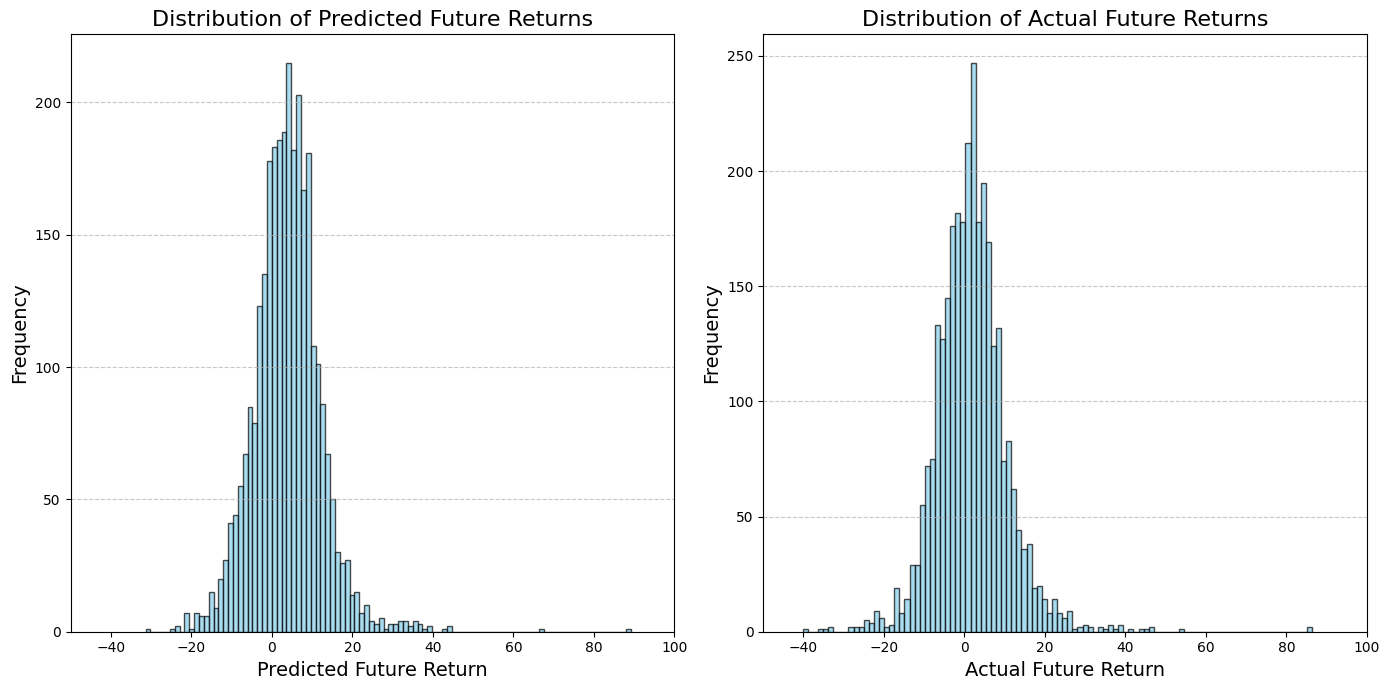

In [62]:
import matplotlib.pyplot as plt

# Sample data from both DataFrames
samp_predicted = test_sampled.sample(3000)
samp_actual = test.sample(3000)

# Set the figure size
plt.figure(figsize=(14, 7))

# Create the first subplot for 'predicted_return_ft'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(
    samp_predicted['predicted_return_ft'],
    bins=100,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)
plt.title('Distribution of Predicted Future Returns', fontsize=16)
plt.xlabel('Predicted Future Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Zoom in by setting the x-axis limits
plt.xlim(-50, 100)

# Create the second subplot for 'futureReturnPercent'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(
    samp_actual['futureReturnPercent'],
    bins=100,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)
plt.title('Distribution of Actual Future Returns', fontsize=16)
plt.xlabel('Actual Future Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Zoom in by setting the x-axis limits
plt.xlim(-50, 100)

# Show the combined plot
plt.tight_layout()
plt.show()


As you can see, the finetuned model produced a distribution of predicted returns that closely resembles the actual future returns. We can conclude that fine tuning did help expand the predicted return range (base models would rarely predict outside the range of -5% to +5% without introducing significant bias).

Now let's evaluate directional accuracy, probability of touch before and after truncating predictions outside the range (-6%,8%) to -6% and +8%, and bin touch rate (original success criteria)

In [67]:
# Function to categorize the predicted return
def categorize_prediction(prediction):
    if prediction >= 8:
        return 'up 8% or more'
    elif 3 <= prediction < 8:
        return 'up 3% to 8%'
    elif -1 <= prediction < 3:
        return 'stable between -1% and 3%'
    elif -6 <= prediction < -1:
        return 'down -1% to -6%'
    elif prediction < -6:
        return 'down -6% or more'
    return np.nan

test_sampled['predicted_return_category'] = test_sampled['predicted_return_ft'].apply(categorize_prediction)

In [68]:
# make sure every prediction was categorized
test_sampled['predicted_return_category'].value_counts().sum()

3000

In [69]:
# take a look at bin predicted return category distribution
test_sampled['predicted_return_category'].value_counts(normalize=True)

,proportion
predicted_return_category,
up 8% or more,0.279667
up 3% to 8%,0.262000
stable between -1% and 3%,0.206667
down -1% to -6%,0.148667
down -6% or more,0.103000


In [63]:
# directional accuracy
dir_accuracy = round((np.sign(test_sampled['predicted_return_ft'] ) == np.sign(test_sampled['futureReturnPercent'])).mean()*100,2)
print(f"Directional Accuracy: {dir_accuracy}%")

Directional Accuracy: 54.17%


54.17% is a very solid directional accuracy given the wide predicted ranges. Worth further investigation/validation.

In [64]:
# Function to calculate the future price based on the current price and predicted return
def calculate_future_price(current_price, prediction):
    return current_price * (1 + (prediction/100))

test_sampled['predicted_future_price'] = test_sampled.apply(lambda row: calculate_future_price(row['adjClose'], row['predicted_return_ft']), axis=1)

# Initialize the 'hit_pred_target' column
test_sampled['hit_pred_target'] = np.nan

# Check if the predicted price target is hit
for idx, row in test_sampled.iterrows():
    symbol = row['symbol']
    date = row['date']
    predicted_price = row['predicted_future_price']
    current_price = row['adjClose']

    # Get future 21 trading days
    future_data = df_iv_vix_sp500.loc['2023-01-01':][(df_iv_vix_sp500.loc['2023-01-01':]['symbol'] == symbol) & (df_iv_vix_sp500.loc['2023-01-01':].index > date)].head(21)

    if len(future_data) < 21:
        # Not enough future data
        continue

    if predicted_price > current_price:
        # Check if adjHigh in the next 21 days is greater than or equal to predicted price
        if (future_data['adjHigh'] >= predicted_price).any():
            test_sampled.at[idx, 'hit_pred_target'] = 1
        else:
            test_sampled.at[idx, 'hit_pred_target'] = 0
    elif predicted_price < current_price:
        # Check if adjLow in the next 21 days is less than or equal to predicted price
        if (future_data['adjLow'] <= predicted_price).any():
            test_sampled.at[idx, 'hit_pred_target'] = 1
        else:
            test_sampled.at[idx, 'hit_pred_target'] = 0

    elif predicted_price == current_price:
            test_sampled.at[idx, 'hit_pred_target'] = 1

probability_of_touch = round(test_sampled['hit_pred_target'].mean() * 100,2)
print(f"Probability of Touch: {probability_of_touch}%")

Probability of Touch: 47.43%


Probability of touch before truncating the predictions outside the range of (-6,8) is 47.43% which again, given the wide prediction range, seems really good. Now let's see what the probability of price touch is after truncating (this should cause the rate to increase)

probability of touch after truncating preds

In [65]:
# truncate preds <-6% to -6% and preds > 8% to 8%
test_sampled['predicted_return_ft_truncated'] = test_sampled['predicted_return_ft'].apply(lambda x: 8.0 if x >= 8.0 else (-6.0 if x <= -6.0 else x))

# Function to calculate the future price based on the current price and predicted return
def calculate_future_price(current_price, prediction):
    return current_price * (1 + (prediction/100))

test_sampled['predicted_future_price_truncated'] = test_sampled.apply(lambda row: calculate_future_price(row['adjClose'], row['predicted_return_ft_truncated']), axis=1)

# Initialize the 'hit_pred_target' column
test_sampled['hit_pred_target_truncated'] = np.nan

# Check if the predicted price target is hit
for idx, row in test_sampled.iterrows():
    symbol = row['symbol']
    date = row['date']
    predicted_price = row['predicted_future_price_truncated']
    current_price = row['adjClose']

    # Get future 21 trading days
    future_data = df_iv_vix_sp500.loc['2023-01-01':][(df_iv_vix_sp500.loc['2023-01-01':]['symbol'] == symbol) & (df_iv_vix_sp500.loc['2023-01-01':].index > date)].head(21)

    if len(future_data) < 21:
        # Not enough future data
        continue

    if predicted_price > current_price:
        # Check if adjHigh in the next 21 days is greater than or equal to predicted price
        if (future_data['adjHigh'] >= predicted_price).any():
            test_sampled.at[idx, 'hit_pred_target_truncated'] = 1
        else:
            test_sampled.at[idx, 'hit_pred_target_truncated'] = 0
    elif predicted_price < current_price:
        # Check if adjLow in the next 21 days is less than or equal to predicted price
        if (future_data['adjLow'] <= predicted_price).any():
            test_sampled.at[idx, 'hit_pred_target_truncated'] = 1
        else:
            test_sampled.at[idx, 'hit_pred_target_truncated'] = 0

    elif predicted_price == current_price:
            test_sampled.at[idx, 'hit_pred_target_truncated'] = 1

probability_of_touch_after_truncating = round(test_sampled['hit_pred_target_truncated'].mean()*100,2)
print(f"Probability of Touch After Truncating: {probability_of_touch_after_truncating}%")

Probability of Touch After Truncating: 54.8%


After truncating the very bullish & bearish predictions, the probability of touch is 54.8% which is a very promising result.

Now to look at the bin touch rate.

In [70]:
# Define the midpoint returns for each bin
bin_to_return_lower_range = {
    'up 3% to 8%': 0.03,
    'down -1% to -6%': -0.01,
    'stable between -1% and 3%': 0.00,
    'down -6% or more': -0.06,
    'up 8% or more': 0.08
}

# Function to calculate the future price based on the current price and predicted return
def calculate_future_price_binned_lower_range(current_price, prediction):
    return current_price * (1 + bin_to_return_lower_range[prediction])

test_sampled['predicted_future_price_binned_lower_range'] = test_sampled.apply(lambda row: calculate_future_price_binned_lower_range(row['adjClose'], row['predicted_return_category']), axis=1)

# Initialize the 'hit_pred_target' column
test_sampled['hit_pred_target_binned_lower_range'] = np.nan

# Check if the predicted price target is hit
for idx, row in test_sampled.iterrows():
    symbol = row['symbol']
    date = row['date']
    predicted_price = row['predicted_future_price_binned_lower_range']
    current_price = row['adjClose']

    # Get future 21 trading days
    future_data = df_iv_vix_sp500.loc['2023-01-01':][(df_iv_vix_sp500.loc['2023-01-01':]['symbol'] == symbol) & (df_iv_vix_sp500.loc['2023-01-01':].index > date)].head(21)

    if len(future_data) < 21:
        # Not enough future data
        continue

    if predicted_price > current_price:
        # Check if adjHigh in the next 21 days is greater than or equal to predicted price
        if (future_data['adjHigh'] >= predicted_price).any():
            test_sampled.at[idx, 'hit_pred_target_binned_lower_range'] = 1
        else:
            test_sampled.at[idx, 'hit_pred_target_binned_lower_range'] = 0
    elif predicted_price < current_price:
        # Check if adjLow in the next 21 days is less than or equal to predicted price
        if (future_data['adjLow'] <= predicted_price).any():
            test_sampled.at[idx, 'hit_pred_target_binned_lower_range'] = 1
        else:
            test_sampled.at[idx, 'hit_pred_target_binned_lower_range'] = 0

    elif predicted_price == current_price:
            test_sampled.at[idx, 'hit_pred_target_binned_lower_range'] = 1

bin_touch_rate = round(test_sampled['hit_pred_target_binned_lower_range'].mean()*100,2)
print(f"Bin Touch Rate: {bin_touch_rate}%")

Bin Touch Rate: 66.7%


Bin touch rate of 66.7% which is good given that ~38% of preds are in the "greater than 8%" or "less than -6% bins"

Now to look at the price touch accuracy broken down by each prediction (rounded to nearest whole prediction percentage)

In [ ]:
test_sampled['predicted_return_ft_truncated_rounded'] = test_sampled['predicted_return_ft_truncated'].round(0)
# Group by 'hit_pred_target_truncated' and calculate the mean for each group
grouped_accuracy = test_sampled.groupby('predicted_return_ft_truncated_rounded')['hit_pred_target_truncated'].mean()

# Print the grouped accuracy
print(grouped_accuracy.round(3))


predicted_return_ft_truncated_rounded
-6.0    0.394
-5.0    0.385
-4.0    0.527
-3.0    0.643
-2.0    0.713
-1.0    0.857
 0.0    0.957
 1.0    0.854
 2.0    0.817
 3.0    0.683
 4.0    0.615
 5.0    0.500
 6.0    0.455
 7.0    0.341
 8.0    0.400
Name: hit_pred_target_truncated, dtype: float64


The model is >=50% accuracy when predicting -4% to +5% which looks great. Predicting the extremes (-6% and +8%) at 40% accuracy also seems impressive given the boldness of the prediction. It is worth investigating these results more.

##**Conclusion**

  * This experiment seemed to validate hypothesis 1: that fine tuning a LLM would result in an expanded range of predictions.

  * It also seemed to validate hypothesiss 2: fine tuning would help the model learn patterns between the information in the prompt and the future return and result in improved prediction performance. However, an additional experiment with a larger test sample size should confirm this.


**Next Steps:**



1.   Test model on larger test sample (~15,000) and record results
2.   Test model on group of tickers it didn't see during fine tuning and record results.
3. Create report that analyzes evaluation metrics over time



